In [228]:
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm.notebook import tqdm
import datetime
import time
%matplotlib inline

from scipy.stats import ttest_ind


In [203]:
# copy paste from Unusualwhales Alerts to csv file.

fname = '2021-04.csv'
columns = [
    'Ticker','Option','Expiry','OI','Volume','Underlying',
    'Max Gain','Max Loss','IV','Sector','OG ask','Daily $ Vol',
    '% Diff','@','Emojis','Tier',
]

def process(fname):
    with open(fname,'r',encoding="ISO-8859-1") as f:
        content=f.read().split('\n')
    og_header = content[0]
    og_odd = content[1::2]
    og_even = content[2:-1:2]
    
    mylist = []
    for i,j in zip(og_odd,og_even):
        og_row = ' '.join([i,j])
        raw = [x for x in og_row.split(' ') if len(x)!=0]
        part0 = raw[:6] # Option ~ Underlying
        part1 = [' '.join(raw[6:8])] # Max Gain
        part2 = [' '.join(raw[8:10])] # Max Loss
        idx=10
        for n,x in enumerate(raw[idx:]):
            if x.startswith('$'):
                break
            idx+=1

        part3 = [raw[10]] # IV 
        part4 = [' '.join(raw[11:idx])] # Sector
        part5 = raw[idx:idx+3]#OG Ask ~ $Diff
        part6 = [' '.join(raw[idx+3:idx+5])] # @
        part7 = [' '.join(raw[idx+5:-1])] # Emoji
        part8 = [raw[-1]] # Tier

        row = []
        row.extend(part0)
        row.extend(part1)
        row.extend(part2)
        row.extend(part3)
        row.extend(part4)
        row.extend(part5)
        row.extend(part6)
        row.extend(part7)
        row.extend(part8)
        rowdict = {x:y for x,y in zip(columns,row)}
        mylist.append(rowdict)

    df = pd.DataFrame(mylist)
    df['duration'] = np.nan
    df['direction'] = np.nan
    df['ret_mean'] = np.nan
    df['ret_std'] = np.nan
    df['ret_sharpe'] = np.nan
    return df

df = process(fname)

In [204]:
df.head()

,Ticker,Option,Expiry,OI,Volume,Underlying,Max Gain,Max Loss,IV,Sector,...,Daily $ Vol,% Diff,@,Emojis,Tier,duration,direction,ret_mean,ret_std,ret_sharpe
0,SPY,$395.00P,2021-06-04,321,10219,$419.71,$6.06 (149.38%),$0.02 (-99.18%),20.45,Miscellaneous,...,"$2,472,998.00",-5.89%,"4/29/2021, 12:52",ð» - Bearishðï¸ - Monthlyð§° - ETFð¦ ...,premium,NaN,NaN,NaN,NaN,NaN
1,FEYE,$19.00C,2021-05-21,195,8240,$20.02,$3.05 (114.79%),$0.76 (-46.48%),42.09,Technology Services,...,"$1,161,840.00",-5.09%,"4/29/2021, 12:51",ðð¼ - Late whale,free,NaN,NaN,NaN,NaN,NaN
2,ET,$10.00C,2021-06-18,1233,33378,$8.74,$1.50 (1150.00%),$0.10 (-16.67%),40.13,Industrial Services,...,"$367,158.00",14.42%,"4/29/2021, 12:50",ðï¸ - Monthlyð - Repeated Bull Flag,premium,NaN,NaN,NaN,NaN,NaN
3,SNAP,$54.00P,2021-05-07,149,12600,$62.12,$2.42 (1052.38%),$0.04 (-80.95%),66.47,Technology Services,...,"$258,300.00",-13.07%,"4/29/2021, 12:49",ð» - Bearishð¦ - Hedgeðð¼ - Late whal...,premium,NaN,NaN,NaN,NaN,NaN
4,QQQ,$315.00P,2021-05-17,57,15538,$340.14,$3.88 (379.01%),$0.02 (-97.53%),25.86,Miscellaneous,...,"$1,235,271.00",-7.39%,"4/29/2021, 12:47",ð» - Bearishð§° - ETFð¦ - Hedgeðï¸ - ...,premium,NaN,NaN,NaN,NaN,NaN


In [205]:
df.shape,df[df.Tier=='free'].shape,df[df.Tier=='premium'].shape

((974, 21), (327, 21), (647, 21))

In [206]:
df.Emojis.apply(lambda x: 'Bear' in x).sum(),df.Emojis.apply(lambda x: 'Bull' in x).sum()

(311, 293)

In [207]:
row = df.iloc[0,:]
row

Ticker                                                       SPY
Option                                                  $395.00P
Expiry                                                2021-06-04
OI                                                           321
Volume                                                     10219
Underlying                                               $419.71
Max Gain                                         $6.06 (149.38%)
Max Loss                                         $0.02 (-99.18%)
IV                                                         20.45
Sector                                             Miscellaneous
OG ask                                                     $2.43
Daily $ Vol                                        $2,472,998.00
% Diff                                                    -5.89%
@                                               4/29/2021, 12:52
Emojis         ð» - Bearishðï¸ - Monthlyð§° - ETFð¦ ...
Tier                     

In [245]:
def evaluate_ticker(row):
    
    if 'Bull' in row['Emojis']:
        direction = 'Bull'
    elif 'Bear' in row['Emojis']:
        direction = 'Bear'
    else:
        direction = np.nan

    # get historical daily price
    symbol = row.Ticker
    tick = yf.Ticker(symbol)
    start_date = datetime.datetime.strptime(row['@'],'%m/%d/%Y, %H:%M')
    start_date+=datetime.timedelta(days=1)
    expiry_date = datetime.datetime.strptime(row.Expiry,'%Y-%m-%d')
    to_date = datetime.datetime.now()
    if expiry_date > to_date:
        end_date = to_date
        duration = np.nan
    else:
        end_date = expiry_date
        duration = (expiry_date-start_date).days

    end_date = end_date.strftime('%Y-%m-%d')
    start_date = start_date.strftime('%Y-%m-%d')

    history = tick.history(start=start_date,end=end_date)
                     
    # check price trend 
    price = history.Close
    ret = np.diff(np.log(price))
    ret_mean = np.mean(ret)
    ret_std = np.std(ret)
    ret_sharpe = ret_mean/ret_std
    
    row.duration = duration
    row.direction = direction
    row.ret_mean = ret_mean
    row.ret_std = ret_std
    row.ret_sharpe = ret_sharpe
    
    return dict(row),history

row_dict,history = evaluate_ticker(row)

myhistory = {}
mydata = []
myerror = []

for index,row in df.iterrows():
    try:
        row_dict,history = evaluate_ticker(row)
        myhistory[index]=history
        mydata.append(row_dict)
    except:
        myerror.append((index,traceback.format_exc()))
    #if index > 4:
    #    break


- WDC: No data found for this date range, symbol may be delisted
- TWTR: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- HIG: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- C: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- FB: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- SQ: No data found for this date range, symbol may be delisted
- UBER: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- TSLA: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- GME: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- TWTR: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- PLTR: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- AMD: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- NGA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- VXRT: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- VXRT: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- APHA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- APHA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by z

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by z

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by z

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- APHA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- APHA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- TSLA: No data found for this date range, symbol may be delisted
- NKLA: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- FCEL: No data found for this date range, symbol may be delisted
- SKLZ: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- STPK: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- SNAP: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- MARA: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- RIOT: No data found for this date range, symbol may be delisted
- QQQ: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- AMC: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- FUBO: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- SNAP: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- NGA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- NKLA: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- NKLA: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- FCEL: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- SKLZ: No data found for this date range, symbol may be delisted
- SKLZ: No data found for this date range, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- GIK: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invali

- NGA: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean 

- GSX: No data found, symbol may be delisted


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


In [295]:
# from above warning,printouts, likely some rest calls are blocked by yahoo likely due to some ddos prevention mechanism kicking in.

ticker: SPY
obtained price start date: 2021-04-30 00:00:00
obtained price end date: 2021-06-03 00:00:00
option: $395.00P
option expiry: 2021-06-04
holding duration till expiration: 34
alert tstamp: 4/29/2021, 12:52
Emojis: ð» - Bearishðï¸ - Monthlyð§° - ETFð¦ - Hedgeðï¸ - Ask Sideðð¼ - Late whaleð - Repeated Bear Flag
alert direction from Emojis column: Bear


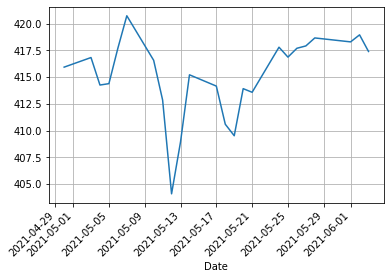

In [296]:
ind=0
print('ticker:',mydata[ind]['Ticker'])
print('obtained price start date:',myhistory[ind].index.min())
print('obtained price end date:',myhistory[ind].index.max())

print('option:',mydata[ind]['Option'])
print('option expiry:',mydata[ind]['Expiry'])
print('holding duration till expiration:', mydata[ind]['duration'])
print('alert tstamp:',mydata[ind]['@'])
print('Emojis:',mydata[ind]['Emojis'])
print('alert direction from Emojis column:',mydata[ind]['direction'])
myhistory[ind].Close.plot()
plt.xticks(rotation=45)
plt.grid(True)

In [297]:
mydata[ind]

{'Ticker': 'SPY',
 'Option': '$395.00P',
 'Expiry': '2021-06-04',
 'OI': '321',
 'Volume': '10219',
 'Underlying': '$419.71',
 'Max Gain': '$6.06 (149.38%)',
 'Max Loss': '$0.02 (-99.18%)',
 'IV': '20.45',
 'Sector': 'Miscellaneous',
 'OG ask': '$2.43',
 'Daily $ Vol': '$2,472,998.00',
 '% Diff': '-5.89%',
 '@': '4/29/2021, 12:52',
 'Emojis': 'ð\x9f\x90» - Bearishð\x9f\x97\x93ï¸\x8f - Monthlyð\x9f§° - ETFð\x9f¦\x94 - Hedgeð\x9f\x9b\x8dï¸\x8f - Ask Sideð\x9f\x9b\x8cð\x9f\x8f¼ - Late whaleð\x9f\x93\x89 - Repeated Bear Flag',
 'Tier': 'premium',
 'duration': 34,
 'direction': 'Bear',
 'ret_mean': 0.0001528897430074324,
 'ret_std': 0.008100991262138328,
 'ret_sharpe': 0.01887296727772001}

In [470]:
print(len(mydata))
ndf = pd.DataFrame(mydata)
ndf = ndf[~ndf.ret_sharpe.isnull()] # remove those with no historical data (very weird, likely blocked by yahoo)
ndf = ndf[~ndf.duration.isnull()] # remove those where expiry is beyond today
ndf = ndf[~ndf.direction.isnull()] # remove no direction

ndf = ndf[(ndf.duration>5)&(ndf.duration < 60)]
print(ndf.shape)

print(len(mydata),len(myhistory))
print(ndf.index.shape)
print(ndf.index.max())

973
(309, 21)
973 973
(309,)
972


scraped alert tstamp range: 4/20/2021, 11:22 4/29/2021, 12:52
number of alerts attempted to scrape 974
number of alerts errored out during scraping 1
number of alerts successfully scraped 309
number of bullish alerts 154
number of bearish alerts 155
* note there are alerts with no directional hint.


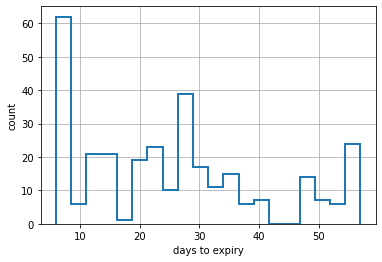

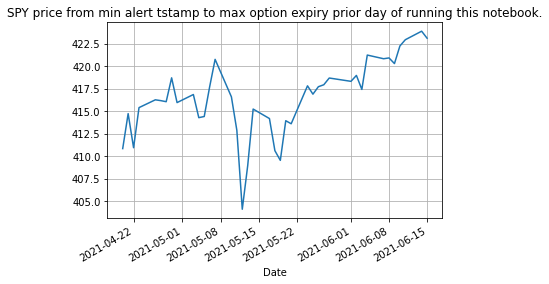

In [471]:
print('scraped alert tstamp range:',ndf['@'].min(),ndf['@'].max())
print('number of alerts attempted to scrape',len(mydata)+len(myerror))
print('number of alerts errored out during scraping',len(myerror))
print('number of alerts successfully scraped',len(ndf))
print('number of bullish alerts',(ndf.direction=='Bull').sum())
print('number of bearish alerts',(ndf.direction=='Bear').sum())
print('* note there are alerts with no directional hint.')

plt.figure(0)
_=plt.hist(ndf.duration,bins=20,histtype='step',linewidth=2)
plt.grid(True)
_=plt.xlabel('days to expiry')
_=plt.ylabel('count')
plt.figure(1)

plt.figure(1)
tick = yf.Ticker("SPY")
start_date = datetime.datetime.strptime(ndf['@'].min(),'%m/%d/%Y, %H:%M').date()
end_date = start_date+datetime.timedelta(days=ndf.duration.max())
tick.history(start=start_date,end=end_date).Close.plot()
plt.title('SPY price from min alert tstamp to max option expiry prior day of running this notebook.')
plt.grid(True)

Ttest_indResult(statistic=-0.07393504166604778, pvalue=0.9411102227059672)


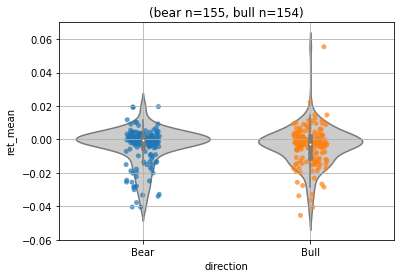

In [472]:
sns.violinplot(x="direction", y="ret_mean", data=ndf, color="0.8")
sns.stripplot(x="direction", y="ret_mean", data=ndf, jitter=True, zorder=1,alpha=0.7)
plt.title(f"(bear n={(ndf.direction=='Bear').sum()}, bull n={(ndf.direction=='Bull').sum()})")
plt.grid(True)
results = ttest_ind(ndf[ndf.direction=='Bull'].ret_mean,ndf[ndf.direction=='Bear'].ret_mean)
print(results)

In [473]:
msg = '''Mean of returns between the bear and bull buckets have to significant difference (p=0.5).
Implying within the analysis period, there is no edge to long/short underlying based on directional alerts.
'''
print(msg)

Mean of returns between the bear and bull buckets have to significant difference (p=0.5).
Implying within the analysis period, there is no edge to long/short underlying based on directional alerts.



(24, 7)
Ticker SPY
Option $395.00P
Expiry 2021-06-04
OI 321
Volume 10219
Underlying $419.71
Max Gain $6.06 (149.38%)
Max Loss $0.02 (-99.18%)
IV 20.45
Sector Miscellaneous
OG ask $2.43
Daily $ Vol $2,472,998.00
% Diff -5.89%
@ 4/29/2021, 12:52
Emojis ð» - Bearishðï¸ - Monthlyð§° - ETFð¦ - Hedgeðï¸ - Ask Sideðð¼ - Late whaleð - Repeated Bear Flag
Tier premium
duration 34
direction Bear
ret_mean 0.0001528897430074324
ret_std 0.008100991262138328
ret_sharpe 0.01887296727772001


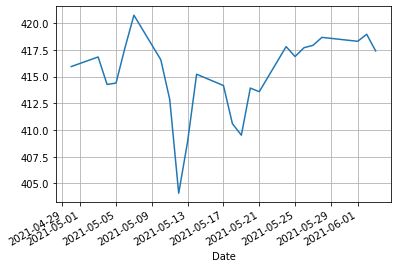

In [474]:
ind=0
print(myhistory[ind].shape)
for k,v in mydata[ind].items():
    print(k,v)
myhistory[ind].Close.plot()
plt.grid(True)

In [475]:
price_at_alert = float(mydata[ind]['Underlying'].strip('$'))
argmax_prct,max_price,max_prct=myhistory[ind].Close.argmax(),myhistory[ind].Close.max(),(myhistory[ind].Close.max()-price_at_alert)/price_at_alert
argmin_prct,min_price,min_prct=myhistory[ind].Close.argmin(),myhistory[ind].Close.min(),(myhistory[ind].Close.min()-price_at_alert)/price_at_alert
print(f'underlying price at alert {price_at_alert}')
print(f'max price {max_price}, max change {max_prct} reached at day {argmax_prct} from alert date')
print(f'min price {min_price}, change {min_prct} reached at day {argmin_prct} from alert date')

underlying price at alert 419.71
max price 420.7434997558594, max change 0.0024624139426256118 reached at day 5 from alert date
min price 404.0880126953125, change -0.037220908019078604 reached at day 8 from alert date


In [476]:
ndf['max_prct']=np.nan
ndf['argmax_prct']=np.nan
ndf['min_prct']=np.nan
ndf['argmin_prct']=np.nan
for ind,row in ndf.iterrows():
    if len(myhistory[ind])==0:
        continue
        
    #price_at_alert = float(mydata[ind]['Underlying'].strip('$').replace(',','')) # likely have parsing issues here.
    price_at_alert = myhistory[ind].Close.iloc[0] #using close price one day after alert!
    
    argmax_prct,max_price,max_prct=myhistory[ind].Close.argmax(),myhistory[ind].Close.max(),(myhistory[ind].Close.max()-price_at_alert)/price_at_alert
    argmin_prct,min_price,min_prct=myhistory[ind].Close.argmin(),myhistory[ind].Close.min(),(myhistory[ind].Close.min()-price_at_alert)/price_at_alert
    ndf.at[ind,'max_prct']=max_prct
    ndf.at[ind,'argmax_prct']=argmax_prct
    ndf.at[ind,'min_prct']=min_prct
    ndf.at[ind,'argmin_prct']=argmin_prct

print(ndf.shape)
fndf=ndf[~ndf.min_prct.isnull()]
print(fndf.shape)

(309, 25)
(302, 25)


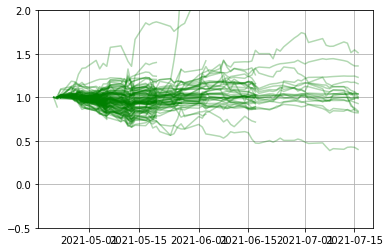

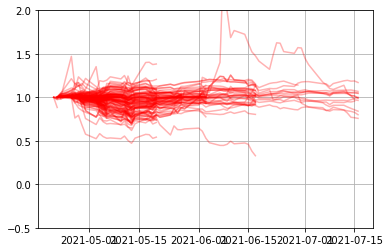

In [477]:
for ind,row in ndf.iterrows():
    if len(myhistory[ind])==0:
        continue
    if row.direction == 'Bull':
        color = 'g'
        plt.figure(0)
    elif row.direction == 'Bear':
        color = 'r'
        plt.figure(1)
    else:
        continue
    
    plt.plot(myhistory[ind].Close/myhistory[ind].Close[0],color=color,alpha=0.3)
plt.figure(0)
plt.ylim(-0.5,2.)
plt.grid(True)
plt.figure(1)
plt.ylim(-0.5,2.)
plt.grid(True)

Ttest_indResult(statistic=-0.2797649871624949, pvalue=0.7798506082942798)


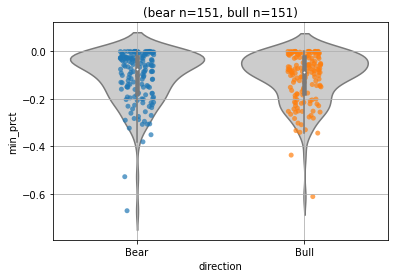

In [478]:
sns.violinplot(x="direction", y="min_prct", data=fndf, color="0.8")
sns.stripplot(x="direction", y="min_prct", data=fndf, jitter=True, zorder=1,alpha=0.7)
plt.title(f"(bear n={(fndf.direction=='Bear').sum()}, bull n={(fndf.direction=='Bull').sum()})")
plt.grid(True)
results = ttest_ind(fndf[fndf.direction=='Bull'].min_prct,fndf[fndf.direction=='Bear'].min_prct)
print(results)

Ttest_indResult(statistic=1.5660667564529656, pvalue=0.11838716492737295)


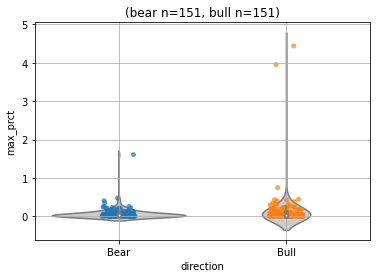

In [479]:
sns.violinplot(x="direction", y="max_prct", data=fndf, color="0.8")
sns.stripplot(x="direction", y="max_prct", data=fndf, jitter=True, zorder=1,alpha=0.7)
plt.title(f"(bear n={(fndf.direction=='Bear').sum()}, bull n={(fndf.direction=='Bull').sum()})")
plt.grid(True)
results = ttest_ind(fndf[fndf.direction=='Bull'].max_prct,fndf[fndf.direction=='Bear'].max_prct)
print(results)

(302, 25)
(299, 25)
Ttest_indResult(statistic=1.7650376239374534, pvalue=0.07858510955906782)


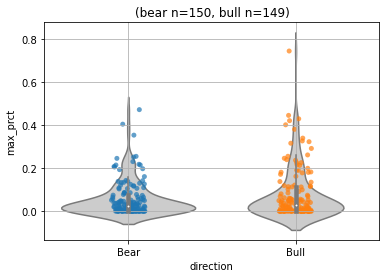

In [480]:
print(fndf.shape)
ffndf=fndf[fndf.max_prct<.8]
print(ffndf.shape)
sns.violinplot(x="direction", y="max_prct", data=ffndf, color="0.8")
sns.stripplot(x="direction", y="max_prct", data=ffndf, jitter=True, zorder=1,alpha=0.7)
plt.title(f"(bear n={(ffndf.direction=='Bear').sum()}, bull n={(ffndf.direction=='Bull').sum()})")
plt.grid(True)
results = ttest_ind(ffndf[ffndf.direction=='Bull'].max_prct,ffndf[ffndf.direction=='Bear'].max_prct)
print(results)

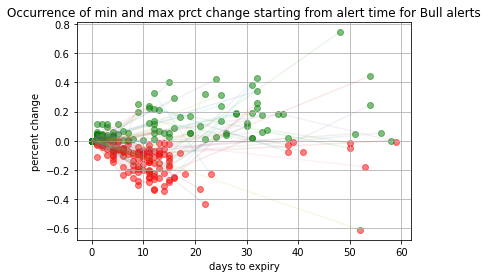

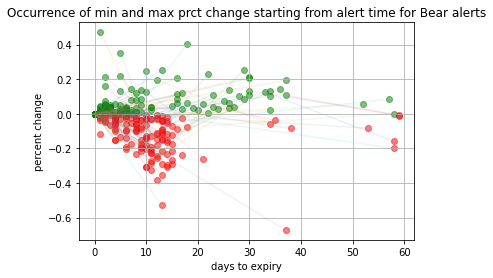

In [481]:
for n,direction in enumerate(['Bull','Bear']):
    ffndf=fndf[fndf.max_prct<.8]
    ffndf=ffndf[ffndf.direction==direction]
    plt.figure(n)
    plt.scatter(ffndf.argmin_prct,ffndf.min_prct,color='red',alpha=0.5)
    plt.scatter(ffndf.argmax_prct,ffndf.max_prct,color='green',alpha=0.5)
    for n,row in ffndf.iterrows():
        x=[row.argmin_prct,row.argmax_prct]
        y=[row.min_prct,row.max_prct]
        plt.plot(x,y,alpha=0.1)
    plt.grid(True)
    _=plt.xlabel('days to expiry')
    _=plt.ylabel('percent change')
    plt.title(f'Occurrence of min and max prct change starting from alert time for {direction} alerts')

In [522]:
# "trade small trade often" - lizjeny tastytrade

In [535]:
# optimize when to exit the trade (stop loss, target )

stop_loss_list = np.linspace(-.5,0,20)
tgt_prct_profit_list = np.linspace(0,1,20)

#print(stop_loss_list)
#print(tgt_prct_profit_list)

ffndf=fndf[fndf.max_prct<.8]

def compute_aggregated_return(stop_loss,tgt_prct):
    blah = []
    for n,row in ffndf.iterrows():
        ret = np.diff(np.log(myhistory[n].Close))
        direction = row.direction

        if direction == 'Bull':
            c = 1
        elif direction == 'Bear':
            c = -1
        else:
            continue

        ret_cumsum = np.cumsum(ret)

        # "backtest" each alert
        # locate stop_loss, record location and ret
        # locate tgt_prct, record location and ret
        # if stop_loss reached earlier than tgt_prct, stop_loss will be the final return.
        # else if tgt_prct reached, tgt_prct will be the final return.
        # else let final return be last cumulative return

        ret_cumsum = ret_cumsum*c
        if len(ret_cumsum) < 7:
            # dont play
            continue

        loss = ret_cumsum < stop_loss
        stop_loss_reached = np.where(loss==True)[0]
        if len(stop_loss_reached) == 0:
            stop_loss_loc = None
        else:
            stop_loss_loc = stop_loss_reached[0]

        win = ret_cumsum > tgt_prct
        tgt_prct_reached = np.where(win==True)[0]
        if len(tgt_prct_reached) == 0:
            tgt_prct_loc = None
        else:
            tgt_prct_loc = tgt_prct_reached[0]

        if stop_loss_loc is not None and tgt_prct_loc is not None:
            if stop_loss_loc < tgt_prct_loc:
                final_ret = ret_cumsum[stop_loss_loc]
            else:
                final_ret = ret_cumsum[tgt_prct_loc]
        elif stop_loss_loc is not None and tgt_prct_loc is None:
            final_ret = ret_cumsum[stop_loss_loc]
        elif tgt_prct_loc is not None:
            final_ret = ret_cumsum[tgt_prct_loc]
        else:
            final_ret = ret_cumsum[-1]

        blah.append(final_ret)
    
    portfolio_return = np.sum(blah)/len(blah)
    return portfolio_return

ret_list = []
for x,stop_loss in enumerate(stop_loss_list):
    for y,tgt_prct in enumerate(tgt_prct_profit_list):
        ret = compute_aggregated_return(stop_loss,tgt_prct)
        row_dict = dict(
            stop_loss=stop_loss,
            tgt_prct=tgt_prct,
            ret=ret,
        )
        ret_list.append(row_dict)
ret_df = pd.DataFrame(ret_list)
ret_df.stop_loss = np.round(ret_df.stop_loss,3)
ret_df.tgt_prct = np.round(ret_df.tgt_prct,3)


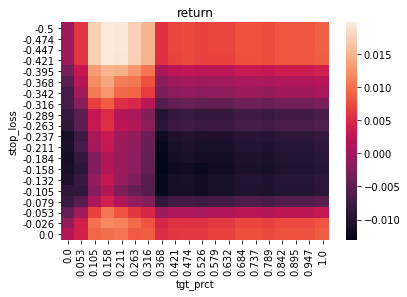

In [539]:
flights = ret_df.pivot(index='stop_loss',columns='tgt_prct', values='ret')
ax = sns.heatmap(flights)
_=plt.title("return")